In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules, apriori
from scipy.stats import pearsonr

In [2]:
df = pd.read_excel("mhs.xls")


In [3]:
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


## Exploratory data analysis

In [4]:
df.isnull().sum()

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

In [5]:
df.describe()   # summary statistics

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


In [6]:
df.info()   # column names, data types, and non-null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


## Feature engineering

Here I will encode the categorical variable to numerical variable using one hot encoding before building the linear model then drop the categorical variable, i proceed to scaling and implementing Lasso regression model for feature selection on the dataset preparing it for modeling

In [7]:
one_hot_encoded = pd.get_dummies(df['RiskLevel'])
df = pd.concat([df, one_hot_encoded], axis=1)
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel,high risk,low risk,mid risk
0,25,130,80,15.0,98.0,86,high risk,1,0,0
1,35,140,90,13.0,98.0,70,high risk,1,0,0
2,29,90,70,8.0,100.0,80,high risk,1,0,0
3,30,140,85,7.0,98.0,70,high risk,1,0,0
4,35,120,60,6.1,98.0,76,low risk,0,1,0


In [8]:
df.dtypes

Age              int64
SystolicBP       int64
DiastolicBP      int64
BS             float64
BodyTemp       float64
HeartRate        int64
RiskLevel       object
high risk        uint8
low risk         uint8
mid risk         uint8
dtype: object

In [9]:
# Dropping the column because it is categorical and irreveant to building a linear model
df.drop('RiskLevel', axis=1, inplace=True) 

In [10]:
# Here am scaling the numerical data, 
# Then for the purpose of knowing which features we will use to build the linear model, I will use a Lasso regression model
# The purpose of the Lasso regrssion model is to understand the correlation of the predictors to the target variable

df_scaled = df.copy()

# select the numerical columns to scale
num_cols = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']

# create a StandardScaler object
scaler = StandardScaler()

# scale the numerical columns
df_scaled[num_cols] = scaler.fit_transform(df[num_cols])

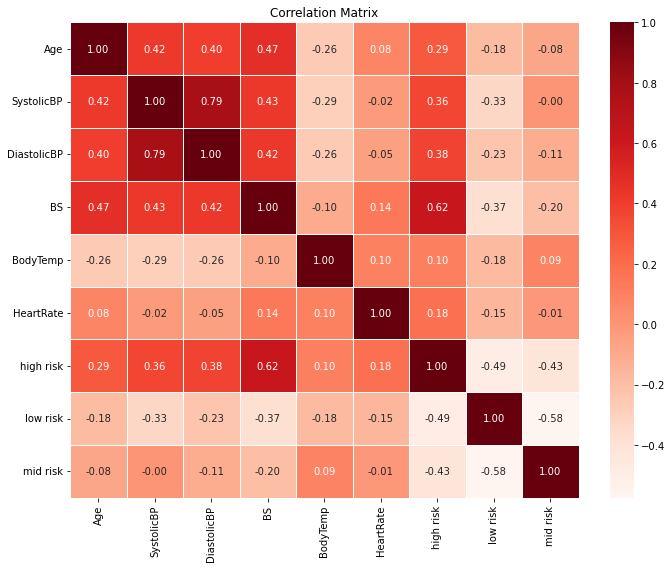

In [11]:
# Compute the correlation matrix
corr_matrix = df_scaled.corr()

# Set the figure size
plt.figure(figsize=(10, 8))

# Create a heatmap with red to black color palette
cmap = sns.color_palette("Reds", as_cmap=True)
sns.heatmap(corr_matrix, annot=True, cmap=cmap, fmt=".2f", linewidths=0.5)

# Set the title and font size
plt.title('Correlation Matrix', fontsize=12)

# Adjust the layout and spacing
plt.tight_layout()

# Display the heatmap
plt.show()


## Linear model to determine the relevant exploratory variables

In [12]:
# select the target variable and the predictor variables
target = 'SystolicBP'
predictors = ['Age', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate', 'high risk', 'low risk', 'mid risk']

# create X and y dataframes
X = df_scaled[predictors]
y = df_scaled[target]

# create a Lasso regression model
lasso = Lasso(alpha=0.1)

# fit the Lasso model to the data
lasso.fit(X, y)

# get the coefficients of the Lasso model
coefficients = lasso.coef_

# print the coefficients of the Lasso model
for col, coef in zip(predictors, coefficients):
    print(col, coef)


Age 0.04029621633223466
DiastolicBP 0.6587087698805304
BS 0.026515188566677377
BodyTemp -0.003940069542961466
HeartRate 0.0
high risk 0.0
low risk -0.0
mid risk 0.0


***Observation***
- The results shows the coefficients of the Lasso regression model. The coefficients indicate the degree and direction of the association between the predictor variables (Age, DiastolicBP, BS, BodyTemp, HeartRate, high risk, low risk, mid risk) and the target variable (SystolicBP).
- For each predictor variable, the coefficient indicates how much the target variable would be expected to change for a one-unit increase in the predictor variable, holding all other variables constant.
- In this case, the results indicate that DiastolicBP has the strongest positive association with SystolicBP, meaning that as DiastolicBP increases, SystolicBP is expected to increase as well. Age and BS also have positive associations with SystolicBP, but to a lesser extent. BodyTemp has a negative association with SystolicBP, meaning that as BodyTemp increases, SystolicBP is expected to decrease. HeartRate, high risk, low risk, mid risk has no association with SystolicBP according to the model, as its coefficient is zero.
- This means the features I will be using to build my linear model are Age, DiastolicBP, BS and BodyTemp.

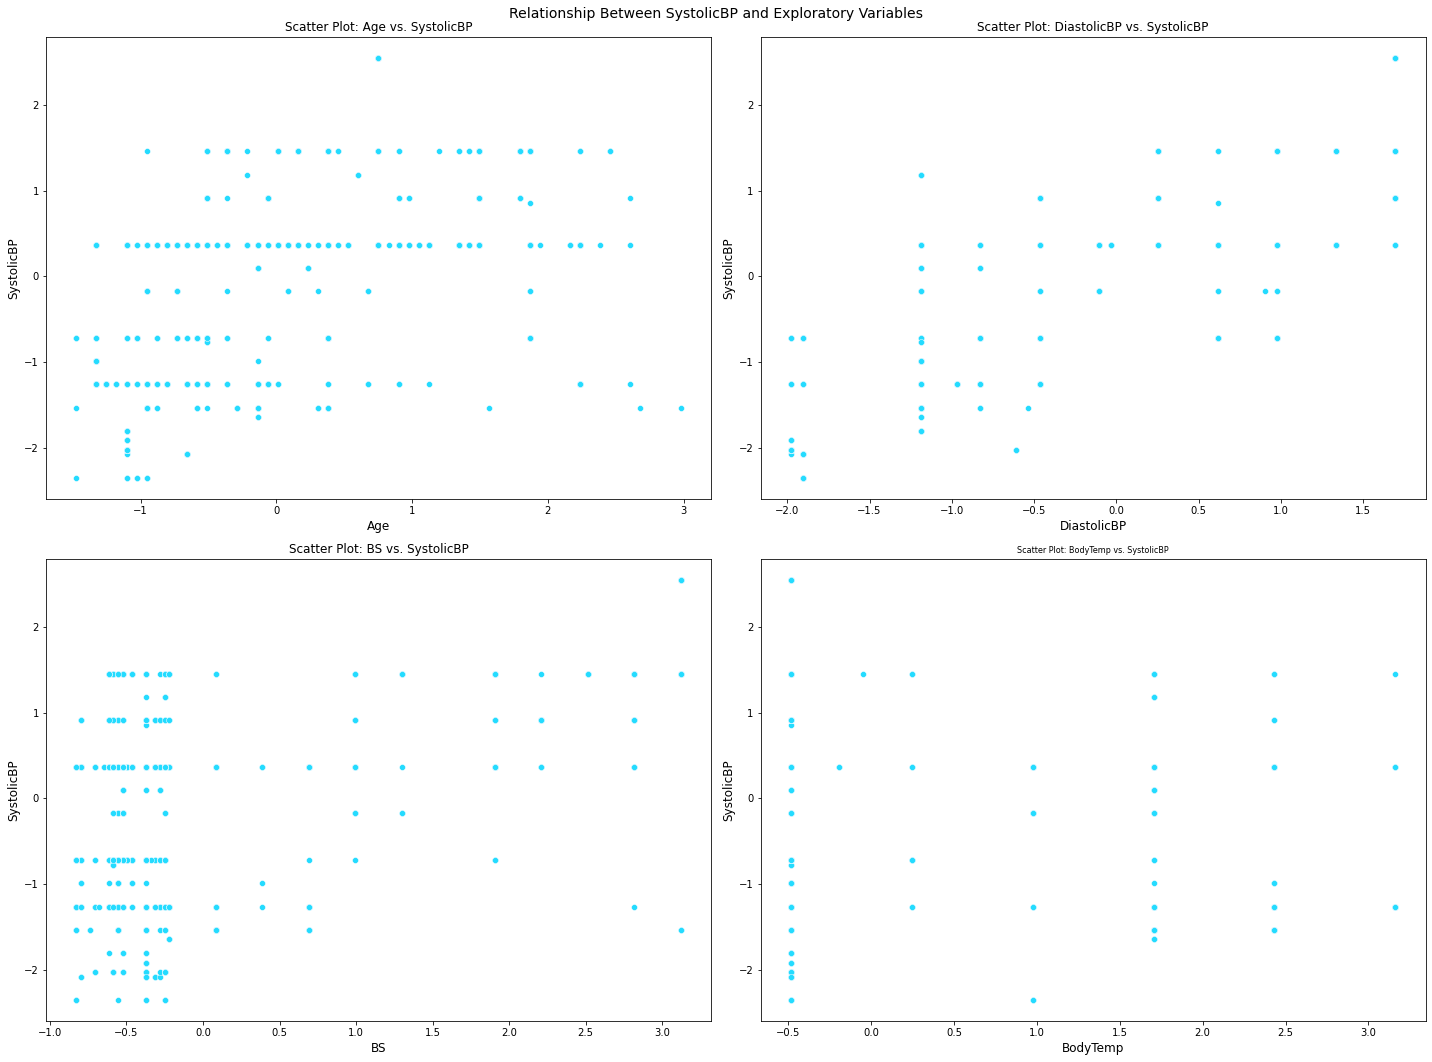

In [13]:
# Set the figure size and color palette
plt.figure(figsize=(20, 15))
sns.set_palette('cool')

# Scatter plot for Age vs. SystolicBP
plt.subplot(2, 2, 1)
sns.scatterplot(x='Age', y='SystolicBP', data=df_scaled)
plt.xlabel('Age', fontsize=12)
plt.ylabel('SystolicBP', fontsize=12)
plt.title('Scatter Plot: Age vs. SystolicBP', fontsize=12)

# Scatter plot for DiastolicBP vs. SystolicBP
plt.subplot(2, 2, 2)
sns.scatterplot(x='DiastolicBP', y='SystolicBP', data=df_scaled)
plt.xlabel('DiastolicBP', fontsize=12)
plt.ylabel('SystolicBP', fontsize=12)
plt.title('Scatter Plot: DiastolicBP vs. SystolicBP', fontsize=12)

# Scatter plot for BS vs. SystolicBP
plt.subplot(2, 2, 3)
sns.scatterplot(x='BS', y='SystolicBP', data=df_scaled)
plt.xlabel('BS', fontsize=12)
plt.ylabel('SystolicBP', fontsize=12)
plt.title('Scatter Plot: BS vs. SystolicBP', fontsize=12)

# Scatter plot for BodyTemp vs. SystolicBP
plt.subplot(2, 2, 4)
sns.scatterplot(x='BodyTemp', y='SystolicBP', data=df_scaled)
plt.xlabel('BodyTemp', fontsize=12)
plt.ylabel('SystolicBP', fontsize=12)
plt.title('Scatter Plot: BodyTemp vs. SystolicBP', fontsize=8)

# Overall Title
plt.suptitle('Relationship Between SystolicBP and Exploratory Variables', fontsize=14)

# Adjust the layout and spacing
plt.tight_layout()

# Display the plots
plt.show()


***Observation***
- There is clearly a good strenght of association in the form of a distinct pattern between the exploratory variables and SystolicBP

## Task 1: Linear Modelling
Here I will build and fit a linear model to investigate the relationship between SystolicBP and the exploratory variables I chose after scaling and fitting a Lasso regression model on the dataset.

In [14]:
# select the target variable and the predictor variables
target = 'SystolicBP'
predictors = ['Age', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']

# create X and y dataframes
X = df_scaled[predictors]
y = df_scaled[target]

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create a linear regression model
model = LinearRegression()

# fit the model to the training data
model.fit(X_train, y_train)

# make predictions on the testing data
y_pred = model.predict(X_test)

# calculate the R squared value of the model
r_squared = r2_score(y_test, y_pred)

# calculate the mean squared error of the model
mse = mean_squared_error(y_test, y_pred)

# print the intercept and coefficients
print('Model Intercept:', model.intercept_)
print('Model Coefficients:', model.coef_)

# print the R squared value and mean squared error of the model
print('R squared:', r_squared)
print('Mean squared error:', mse)



Model Intercept: 0.01210402365077058
Model Coefficients: [ 0.09874302  0.69874555  0.07396999 -0.0818882   0.00451921]
R squared: 0.6221718011657567
Mean squared error: 0.36132630670250604


***Observation***
- Judging by the result, the model did not perform well and that can be due to some reasons I will love to investigate to but it is beyond the scope of this project, here are the possible reasons:

- Insufficient data: If the dataset is too small, the model may not be able to capture the underlying patterns in the data.

- Non-linear relationship between the features and the target: Linear regression assumes that there is a linear relationship between the features and the target. If the relationship is non-linear, then the model may not perform well.

- Outliers: Outliers can have a significant impact on the regression line and can pull it away from the main trend, leading to poor performance.

- Multicollinearity: If the features used in the model are highly correlated, then it can lead to unstable and unreliable estimates of the regression coefficients, leading to poor performance.

## Task 2: Applying the principal component analysis (PCA) to reduce number of variables.

In [15]:
# First lets see the dataframe

df_scaled.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,high risk,low risk,mid risk
0,-0.361738,0.913396,0.255023,1.905890,-0.485215,1.446956,1,0,0
1,0.380777,1.457027,0.975539,1.298340,-0.485215,-0.532088,1,0,0
2,-0.064732,-1.261127,-0.465493,-0.220537,0.973884,0.704815,1,0,0
3,0.009519,1.457027,0.615281,-0.524312,-0.485215,-0.532088,1,0,0
4,0.380777,0.369765,-1.186009,-0.797710,-0.485215,0.210054,0,1,0


Explained variance ratio: [4.03123242e-01 1.79800264e-01 1.30364280e-01 1.06897687e-01
 7.74157061e-02 5.27092676e-02 2.91226598e-02 2.05668942e-02
 1.89895403e-33]
       Feature   Loading
1   SystolicBP  0.520054
2  DiastolicBP  0.512701
3           BS  0.434953
0          Age  0.427925
6    high risk  0.140229
5    HeartRate  0.032884
8     mid risk -0.037958
7     low risk -0.102271
4     BodyTemp -0.248457


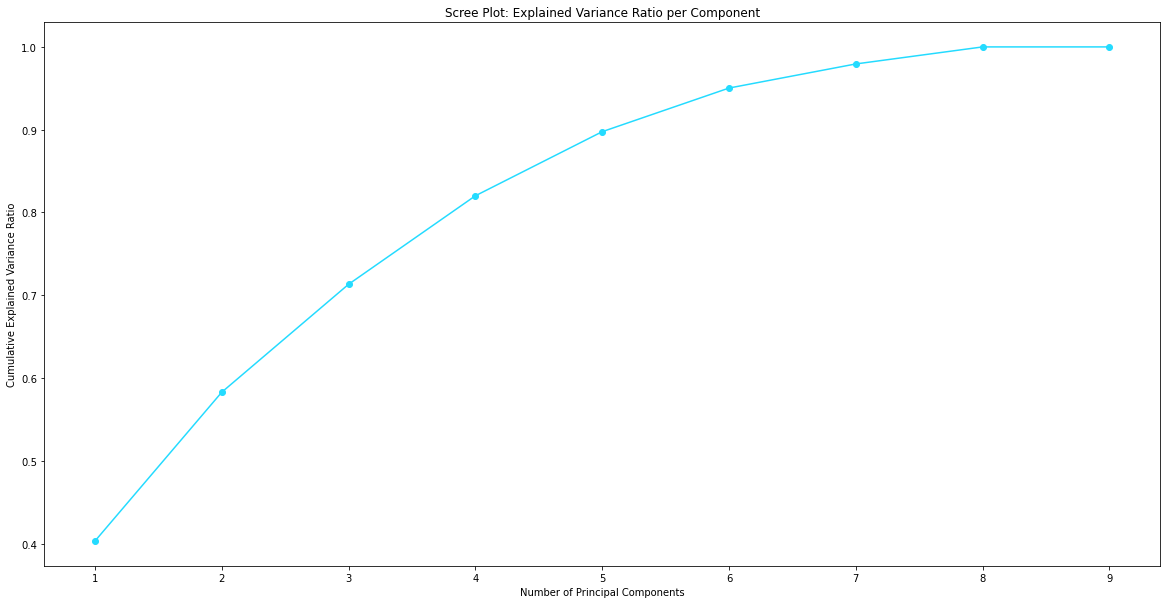

In [16]:
# Apply the PCA
pca = PCA(n_components=9)
X_pca = pca.fit_transform(df_scaled[['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 
                              'HeartRate', 'high risk', 'low risk', 'mid risk']])

# Print the explained variance ratio
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

# Get the index of the component with the highest explained variance ratio
best_pc_idx = np.argmax(pca.explained_variance_ratio_)

# Get the loadings (weights) of the features for the best performing principal component
best_pc_loadings = pca.components_[best_pc_idx]

# Create a dataframe to display the loadings for each feature
loadings_df = pd.DataFrame({'Feature': df_scaled.columns, 'Loading': best_pc_loadings})

# Print the loadings in descending order
print(loadings_df.sort_values(by='Loading', ascending=False))

# Calculate the cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Set figure size and plot the scree plot
plt.figure(figsize=(20, 10))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Scree Plot: Explained Variance Ratio per Component')

# Show the plot
plt.show()

***Observation***
- The explained_variance_ratio_ attribute of the PCA object indicates the proportion of the total variance in the data that is explained by each principal component. In this case, we have five principal components and their corresponding explained variance ratios are [0.40312324 0.17980026 0.13036428 0.10689769 0.07741571].

- The first principal component explains the highest proportion of the variance in the data (40.3%), followed by the second (17.9%) and the third (13.0%) principal components. The fourth and fifth principal components explain smaller proportions of the variance (10.7% and 7.7%, respectively).

- The loadings (weights) of each feature in the best performing principal component (the first principal component) are shown in the second part of the output. The features are ranked based on their loadings in descending order. The top four features with the highest positive loadings are SystolicBP, DiastolicBP, BS, and Age. This suggests that these features are highly correlated with each other and contribute the most to the variance in the data. The features BodyTemp, low risk, mid risk, and HeartRate have negative or small loadings, indicating that they are less important for explaining the variance in the data.

- Overall, this observation suggests that the first principal component captures the variation in blood pressure and age, which are important factors for maternal health outcomes. This is consistent with the earlier analysis where we identified blood pressure as a significant predictor of maternal health.

***Observation***
- This shows that the optimum number of component to retain is 8

## Task 3: Investigate the relationship between age and heartrate by means of age grouping

In [17]:
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,high risk,low risk,mid risk
0,25,130,80,15.0,98.0,86,1,0,0
1,35,140,90,13.0,98.0,70,1,0,0
2,29,90,70,8.0,100.0,80,1,0,0
3,30,140,85,7.0,98.0,70,1,0,0
4,35,120,60,6.1,98.0,76,0,1,0


In [18]:
max_age = df['Age'].max()
print("The maximum age is:", max_age)

The maximum age is: 70


Mean Heart Rate by Age Group:
  Age_Group  HeartRate
0  Under 25  73.136364
1     25-35  75.400000
2     35-45  75.606383
3     45-55  76.364341
4     55-65  72.674419
5   Over 65  78.000000


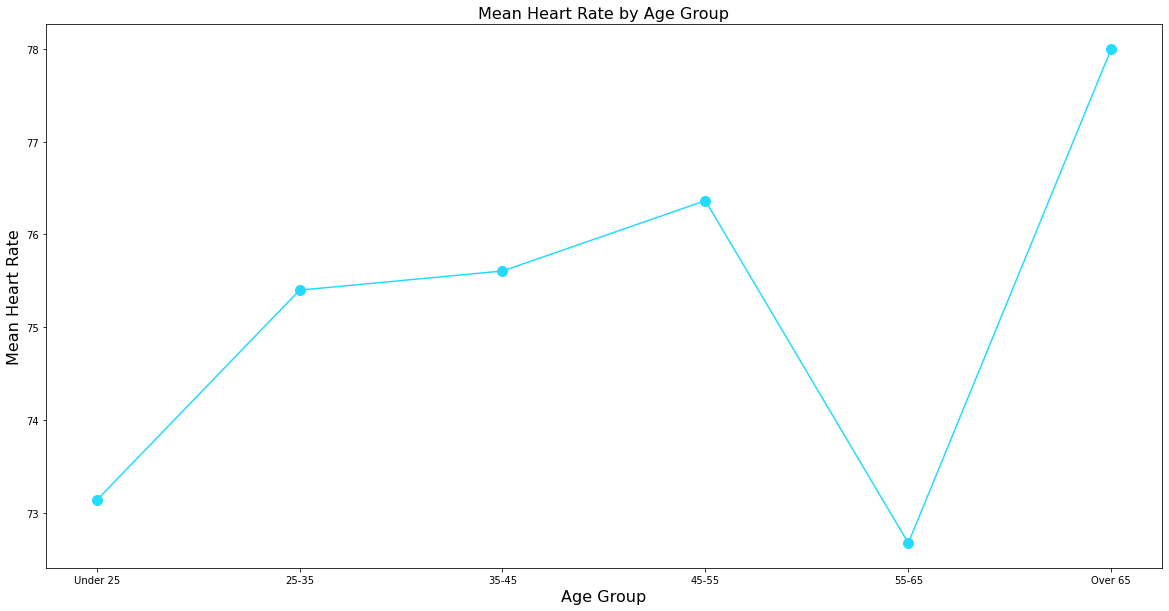

In [19]:
# Group the ages into categories with intervals of 10
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 25, 35, 45, 55, 65, 100], 
                         labels=['Under 25', '25-35', '35-45', '45-55', '55-65', 'Over 65'])

# Calculate the mean heart rate for each age group
age_group_means = df.groupby('Age_Group')['HeartRate'].mean().reset_index()

# Print the mean heart rate for each age group
print("Mean Heart Rate by Age Group:")
print(age_group_means)

# Set figure size
plt.figure(figsize=(20, 10))

# Define the cool color palette from seaborn
colors = sns.color_palette('cool', len(age_group_means))

# Create a line plot of the mean heart rate for each age group using the color palette
plt.plot('Age_Group', 'HeartRate', data=age_group_means, 
         color=colors[0], marker='o', markersize=10)

# Add labels and a title
plt.xlabel('Age Group', fontsize=16)
plt.ylabel('Mean Heart Rate', fontsize=16)
plt.title('Mean Heart Rate by Age Group', fontsize=16)

# Show the plot
plt.show()


***Observation***
- The highest mean heart rate was highest for age group above 65 and least for age group under 25 although there are some disperities in the mean heart rate for age groups between these extremes

***Note***
- I chose these intervals because they cover a wide range of ages and allow me to observe the changes in heart rate across different stages of adulthood. I grouped the data into larger intervals of 10 years to ensure that each group have enough observations for meaningful analysis.

## Task 4: Describe how would you investigate associations between pairs high/high, normal/normal, and low/low diastolic and systolic blood pressure

To investigate associations between pairs of high/high, normal/normal, and low/low diastolic and systolic blood pressure, we can use a contingency table and calculate measures of association such as odds ratio, chi-square, and Fisher's exact test. We can create a contingency table with four cells, where each cell represents the number of individuals with a particular combination of systolic and diastolic blood pressure. Then we can calculate the measures of association for each combination, which includes; 
1. Support: The proportion of patients who have both high systolic and diastolic blood pressure, or normal systolic and diastolic blood pressure, or low systolic and diastolic blood pressure.
2. Confidence: The proportion of patients who have high systolic blood pressure given that they have high diastolic blood pressure, or normal systolic blood pressure given that they have normal diastolic blood pressure, or low systolic blood pressure given that they have low diastolic blood pressure.
3. Conviction: The ratio of the probability that a patient with high systolic blood pressure also has high diastolic blood pressure to the probability that a patient with high systolic blood pressure does not have high diastolic blood pressure, or the ratio of the probability that a patient with normal systolic blood pressure also has normal diastolic blood pressure to the probability that a patient with normal systolic blood pressure does not have normal diastolic blood pressure, or the ratio of the probability that a patient with low systolic blood pressure also has low diastolic blood pressure to the probability that a patient with low systolic blood pressure does not have low diastolic blood pressure.
4. Lift: The ratio of the confidence of a rule to the support of the antecedent, or the proportion of patients who have high systolic and diastolic blood pressure given that they have both high systolic blood pressure and high diastolic blood pressure divided by the proportion of patients who have high systolic blood pressure.



In [20]:
# # Load the dataset
# data = pd.read_csv("maternal_health_data.csv")

# Create a new column to represent the blood pressure category
def categorize_bp(row):
    if row['SystolicBP'] >= 140 and row['DiastolicBP'] >= 90:
        return 'high/high'
    elif 110 <= row['SystolicBP'] < 140 and 70 <= row['DiastolicBP'] < 90:
        return 'normal/normal'
    else:
        return 'low/low'

df['BP_Category'] = df.apply(categorize_bp, axis=1)

# Create a list of lists of BP categories for each patient
bp_categories = df.groupby('Age')['BP_Category'].apply(list).tolist()

# Use TransactionEncoder to create a binary matrix
te = TransactionEncoder()
te_matrix = te.fit_transform(bp_categories)

# Convert the matrix to a pandas DataFrame
bp_df = pd.DataFrame(te_matrix, columns=te.columns_)

# Generate frequent itemsets
frequent_itemsets = apriori(bp_df, min_support=0.05, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Print the rules for each pair
for bp_pair in ['high/high', 'normal/normal', 'low/low']:
    print(f"Associations for {bp_pair} pair:\n")
    pair_rules = rules[rules['antecedents'] == {bp_pair}]
    for i, row in pair_rules.iterrows():
        print(f"Rule {i+1}: {row['antecedents']} => {row['consequents']}")
        print(f"Support: {row['support']:.3f}")
        print(f"Confidence: {row['confidence']:.3f}")
        print(f"Conviction: {row['conviction']:.3f}")
        print(f"Lift: {row['lift']:.3f}\n")


Associations for high/high pair:

Rule 2: frozenset({'high/high'}) => frozenset({'normal/normal'})
Support: 0.280
Confidence: 0.778
Conviction: 1.350
Lift: 1.111

Rule 8: frozenset({'high/high'}) => frozenset({'low/low', 'normal/normal'})
Support: 0.240
Confidence: 0.667
Conviction: 1.320
Lift: 1.190

Associations for normal/normal pair:

Rule 1: frozenset({'normal/normal'}) => frozenset({'high/high'})
Support: 0.280
Confidence: 0.400
Conviction: 1.067
Lift: 1.111

Rule 6: frozenset({'normal/normal'}) => frozenset({'high/high', 'low/low'})
Support: 0.240
Confidence: 0.343
Conviction: 1.096
Lift: 1.224

Associations for low/low pair:

Rule 7: frozenset({'low/low'}) => frozenset({'high/high', 'normal/normal'})
Support: 0.240
Confidence: 0.293
Conviction: 1.018
Lift: 1.045



**Observations**

- For the 'high/high' pair, there are two rules. The first rule shows that if a patient has high/high blood pressure, they are likely to have normal/normal blood pressure as well with a confidence level of 0.778. The second rule indicates that if a patient has high/high blood pressure, they are likely to have both normal/normal and low/low blood pressure with a confidence level of 0.667.
- For the 'normal/normal' pair, there are two rules. The first rule suggests that if a patient has normal/normal blood pressure, they are likely to have high/high blood pressure as well with a confidence level of 0.400. The second rule indicates that if a patient has normal/normal blood pressure, they are likely to have both low/low and high/high blood pressure with a confidence level of 0.343.
- For the 'low/low' pair, there is only one rule. The rule suggests that if a patient has low/low blood pressure, they are likely to have both high/high and normal/normal blood pressure with a confidence level of 0.293.
- In general, the analysis shows that there is some association between the three blood pressure categories. Patients with one category of blood pressure are likely to have other categories as well. For example, patients with high/high blood pressure are likely to have both normal/normal and low/low blood pressure as well. These associations can help healthcare providers better understand the health conditions of their patients and take appropriate measures to manage their health.

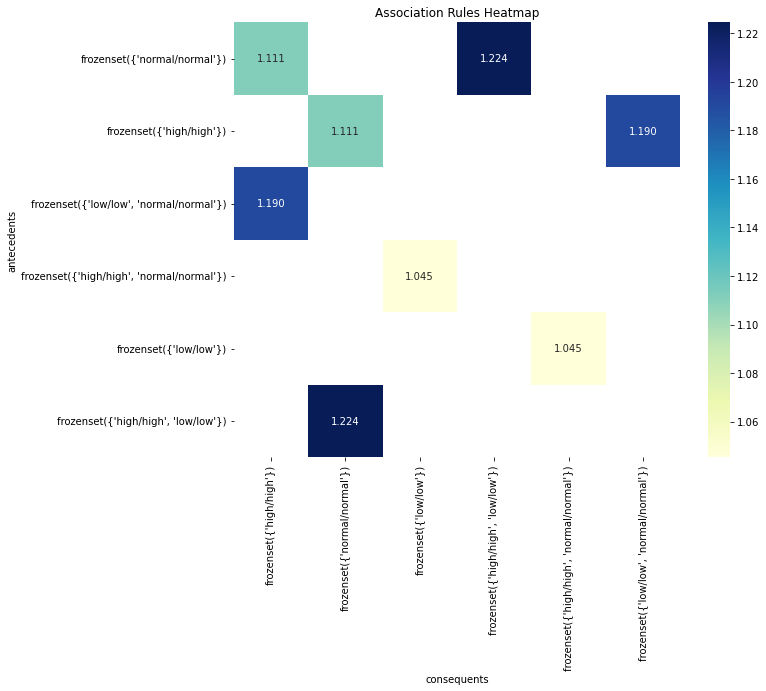

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pivot table of the association rules
pivot_table = rules.pivot(index='antecedents', columns='consequents', values='lift')

# Set figure size
plt.figure(figsize=(10, 8))

# Create a heatmap
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu")

# Set the title
plt.title("Association Rules Heatmap")

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Display the heatmap
plt.show()


## Task 5: To find clusters of patients with similar Systolic BP, I will use KMeans clustering

C:\Users\DELL\anaconda3copy\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


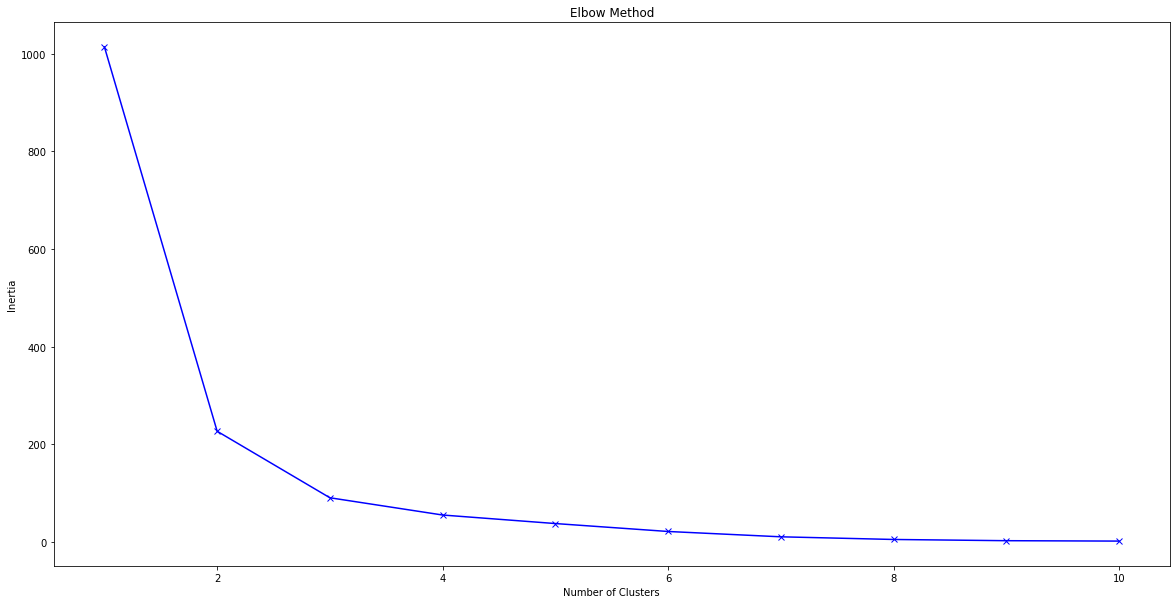

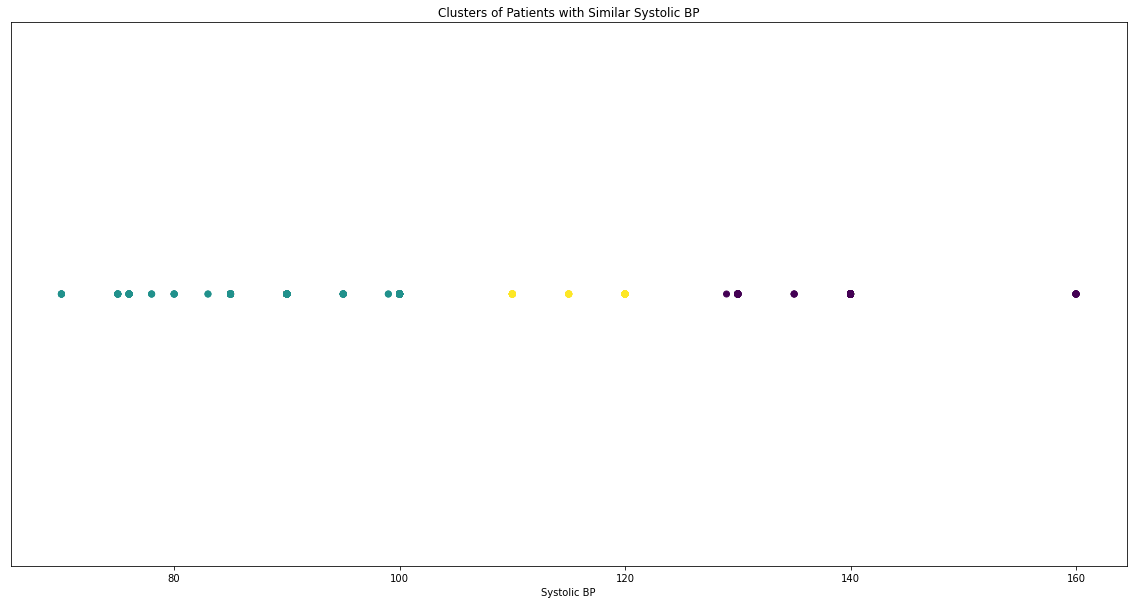

In [22]:
# Create a dataframe with only the systolic BP column
systolic_df = df[['SystolicBP']]

# Scale the data
scaler = StandardScaler()
systolic_scaled = scaler.fit_transform(systolic_df)

# Use the elbow method to determine the optimal number of clusters
k_values = range(1, 11)
inertias = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(systolic_scaled)
    inertias.append(kmeans.inertia_)

# Set figure size
plt.figure(figsize=(20,10))

# Plot the elbow curve
plt.plot(k_values, inertias, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

# Show the plot
plt.show()

# Based on the elbow method, choose k=3
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(systolic_scaled)

# Add the cluster labels to the dataframe
df['Cluster'] = kmeans.labels_

# Visualize the clusters
plt.figure(figsize=(20,10))
plt.scatter(df['SystolicBP'], [0] * len(df), c=df['Cluster'])
plt.title('Clusters of Patients with Similar Systolic BP')
plt.xlabel('Systolic BP')
plt.yticks([])

# Show the plot
plt.show()


**Observation**
- The code performs k-means clustering on a dataset consisting of systolic blood pressure values of patients. The elbow method is used to determine the optimal number of clusters, and based on the plot of the within-cluster sum of squares (inertia) against the number of clusters, it appears that three clusters is a reasonable choice. The code then fits a k-means model with k=3 and adds the cluster labels to the original dataframe. Finally, a scatter plot is created where each patient is represented as a point on the x-axis (based on their systolic BP value) and color-coded according to their assigned cluster label. This plot provides a visual representation of how patients with similar systolic BP values are grouped together into different clusters.

## Task 6: Calculating the correlation between age and systolic BP. with result interpretations

In [23]:
# Calculate the correlation between age and systolic BP
corr, _ = pearsonr(df['Age'], df['SystolicBP'])

print("Correlation between Age and Systolic BP:", corr)



Correlation between Age and Systolic BP: 0.4160454479747328


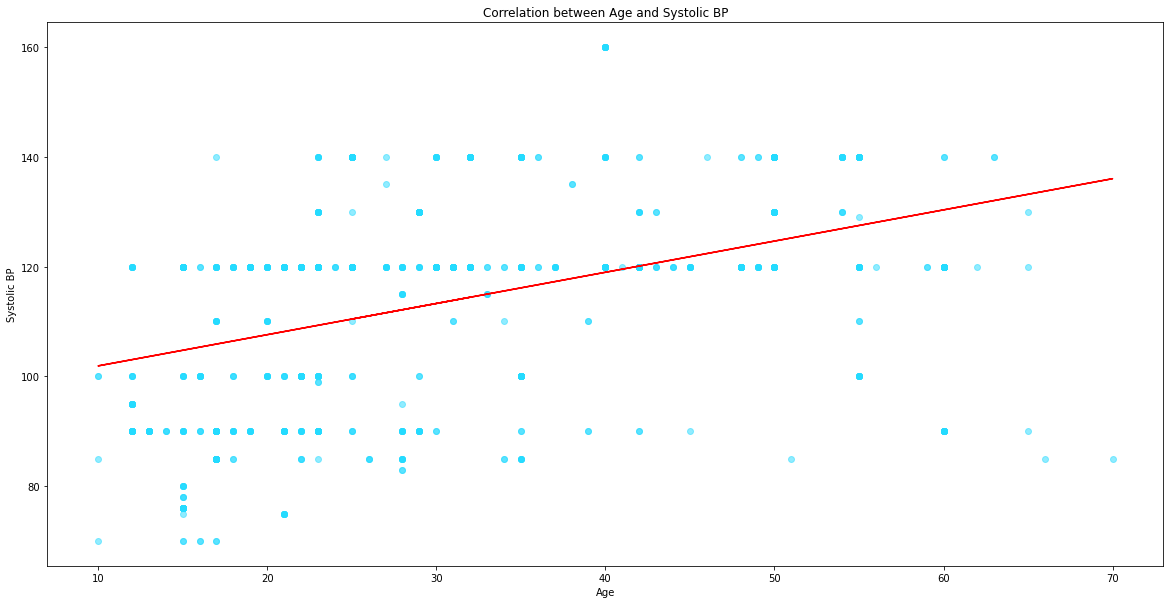

In [27]:
import matplotlib.pyplot as plt

# Plotting the scatter plot
plt.figure(figsize=(20, 10))
plt.scatter(df['Age'], df['SystolicBP'], alpha=0.5)
plt.title('Correlation between Age and Systolic BP')
plt.xlabel('Age')
plt.ylabel('Systolic BP')

# Adding a trendline
z = np.polyfit(df['Age'], df['SystolicBP'], 1)
p = np.poly1d(z)
plt.plot(df['Age'], p(df['Age']), color='red')

# Display the plot
plt.show()



**Interpretation of result**

- The correlation coefficient is a numerical value ranging from -1 to 1 that indicates the strength and direction of the linear relationship between two variables. A positive correlation coefficient suggests that the two variables tend to increase or decrease together, while a negative correlation coefficient indicates that they tend to move in opposite directions.

- In the case of age and systolic BP, the correlation coefficient of 0.4160454479747328 implies that there is a moderately positive relationship between age and systolic BP. This means that as age increases, systolic BP also tends to increase, but the relationship is not extremely strong. A correlation coefficient of 1 would indicate a perfect positive relationship, while a coefficient of -1 would indicate a perfect negative relationship. A coefficient of 0 would suggest that there is no linear relationship between age and systolic BP.